In [19]:
import os
import sys
project_name = 'ai_synth'
src_dir_relative_path = '../../../src'
if src_dir_relative_path not in sys.path:
    sys.path.append(src_dir_relative_path)

from pathlib import Path
from torchaudio.transforms import Spectrogram, MelSpectrogram, Resample
from model.loss import spectral_loss
from synth.synth_architecture import SynthModular
from main_hp_search_dec_only import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants
from utils.visualization_utils import  calc_loss_vs_param_range, plot_loss_vs_param


import matplotlib
matplotlib.pyplot.ion()

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

notebook_path = Path('.').resolve()
dir_list = notebook_path.parts
root_index = dir_list.index(project_name)
abs_path = Path(*dir_list[:root_index+1])

project_root = abs_path

In [20]:
# Setup experiment

exp_name = 'del_visualization'
dataset_name = 'saw_square_mix_single'
device = 'cpu'

config_path = os.path.join(project_root, 'configs', 'optimization_analysis', 'saw_square_mix_single_synth_config_hp_search.yaml')
data_path = os.path.join(project_root, 'data', dataset_name, 'train', '')

cfg = configure_experiment(exp_name, dataset_name, config_path, debug=True)

synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

dataset = AiSynthDataset(data_path, noise_std=0)

Deleting previous experiment...


In [21]:
target_sample = dataset[0]
target_signal, target_param_dict, signal_index = target_sample

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)
print(target_param_dict)

{(0, 0): {'operation': 'saw_square_osc', 'parameters': {'square_amp': 0.8431000412323669, 'saw_amp': 0.7574084575955419, 'freq': 783.9908719634988, 'factor': 0.39377955108825136}}}


In [22]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants,
                                          device=device)

100%|██████████| 100/100 [00:00<00:00, 155.95it/s]


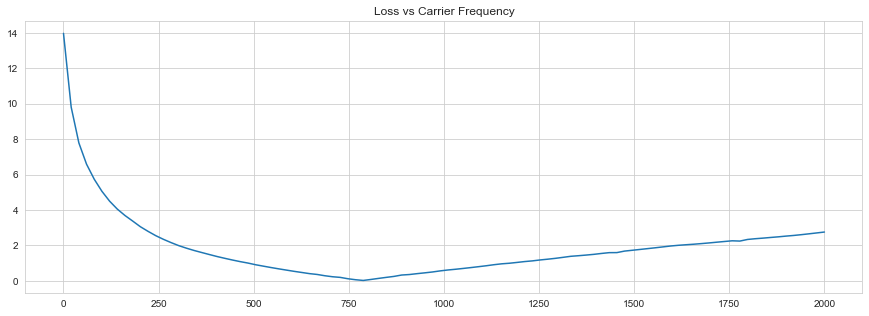

In [23]:
param_name = 'freq'
cell_index = (0, 0)
min_val = 0
max_val = 2000
n_steps = 100

loss_vals, param_range = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler,
                                                  param_name, cell_index, min_val=min_val, max_val=max_val, n_steps=n_steps)
plot_loss_vs_param(param_range, loss_vals, title='Loss vs Carrier Frequency')

100%|██████████| 1000/1000 [00:06<00:00, 159.59it/s]


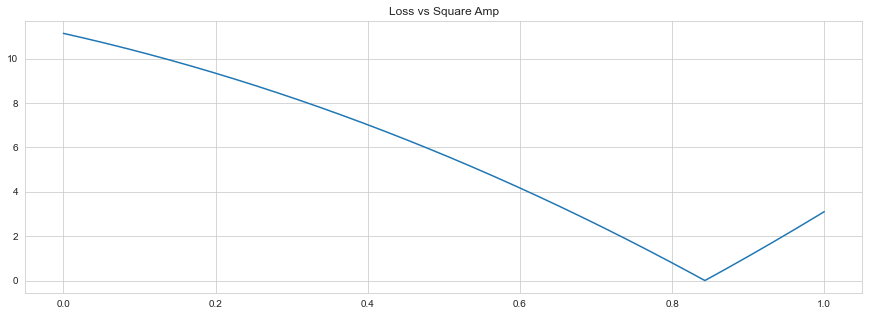

In [24]:
param_name = 'square_amp'
cell_index = (0, 0)
min_val = 0
max_val = 1
n_steps = 1000

loss_vals, param_range = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler,
                                                  param_name, cell_index, min_val=min_val, max_val=max_val, n_steps=n_steps)
plot_loss_vs_param(param_range, loss_vals, title='Loss vs Square Amp')


100%|██████████| 1000/1000 [00:06<00:00, 151.03it/s]


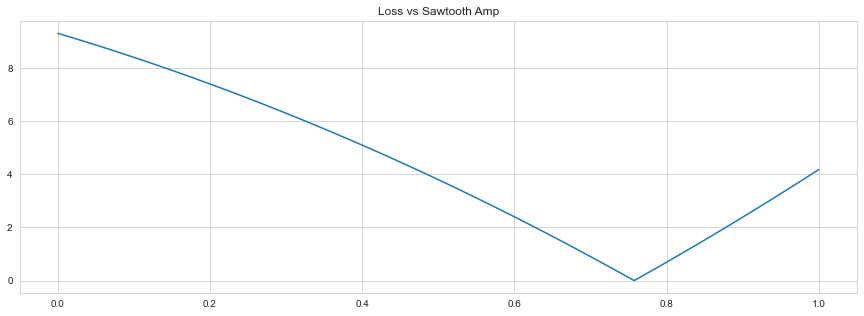

In [25]:
param_name = 'saw_amp'
cell_index = (0, 0)
min_val = 0
max_val = 1
n_steps = 1000

loss_vals, param_range = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler,
                                                  param_name, cell_index, min_val=min_val, max_val=max_val, n_steps=n_steps)
plot_loss_vs_param(param_range, loss_vals, title='Loss vs Sawtooth Amp')


100%|██████████| 1000/1000 [00:06<00:00, 156.89it/s]


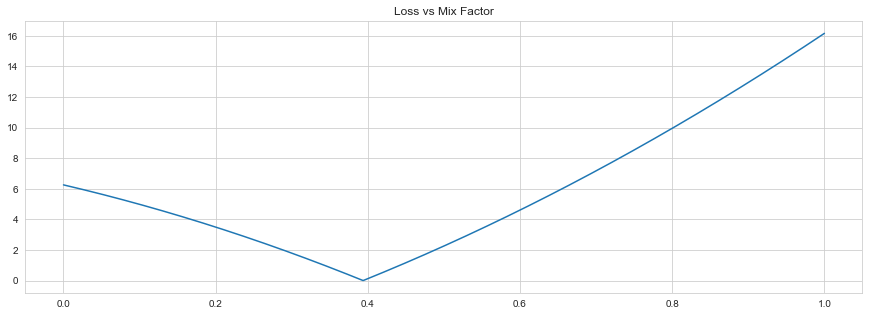

In [26]:
param_name = 'factor'
cell_index = (0, 0)
min_val = 0
max_val = 1
n_steps = 1000

loss_vals, param_range = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler,
                                                  param_name, cell_index, min_val=min_val, max_val=max_val, n_steps=n_steps)
plot_loss_vs_param(param_range, loss_vals, title='Loss vs Mix Factor')

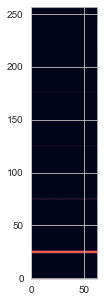

In [27]:
spec_op = Spectrogram(n_fft=512)

plt.figure(figsize=(12, 5))
target_spec = spec_op(target_signal.cpu())

# update_params = copy.deepcopy(target_param_dict)
#
# update_params[(0, 0)]['parameters'].update({'freq_c': 200})
# synth.update_cells_from_dict(update_params)
signal, _ = synth.generate_signal(signal_duration=1.0)

pred_spec = spec_op(signal.cpu().detach())

plt.imshow(target_spec.squeeze(), origin='lower')
